In [2]:
grand_prix = "Saudi Arabia"

safety_car_laps = ["7-10"]  # FORMAT: list of safety cars, start lap to resume lap (i.e. first non-safety car lap)

In [35]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.dates as mdates
from matplotlib import font_manager
from matplotlib.ticker import FixedLocator

import seaborn as sns
from sklearn.linear_model import LinearRegression

from timple.timedelta import strftimedelta
from datetime import datetime, timedelta


import fastf1 as f1
import fastf1.plotting
from fastf1.core import Laps
from fastf1.ergast import Ergast
from fastf1 import utils

ergast = Ergast(result_type='pandas')

with open("../season_info.json") as file:
    season_info = json.loads(file.read())
teams = season_info["teams"]
team_colours = season_info["team_colours"]
tyre_colours = season_info["tyre_colours"]
drivers = season_info["drivers"]
races = season_info["races"]
current_race = races[grand_prix]


fastf1.plotting.setup_mpl(mpl_timedelta_support=True, color_scheme="fastf1", misc_mpl_mods=True)

font_files = font_manager.findSystemFonts(fontpaths=None, fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

font = font_manager.FontProperties(family="Formula1", weight="normal", style="normal", size=16)

data = f1.get_session(year=2024, gp=grand_prix, identifier="R")
data.load()
LAPS = data.laps

all_laps_by_team = dict()

for team1 in teams:

    team_data = LAPS[LAPS["Team"] == team1]

    all_laps_by_team[team1] = team_data.reset_index()


# encoding safety car laps into a tuple in a list
sc_laps = list()
for sc in safety_car_laps:
    laps = sc.split("-")
    start_lap = int(laps[0])
    end_lap = int(laps[1])

    sc_laps.append((start_lap, end_lap))

circuit_info = data.get_circuit_info()


core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.3.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
Request for URL https://ergast.com/api/f1/2024/2/results.json failed; using cached response
Traceback (most recent call last):
  File "c:\Users\maxvo\AppData\Local\Programs\Python\Python312\Lib\site-packages\requests_cache\session.py", line 290, in _resend
    response.raise_for_status()
  File "c:\Users\maxvo\AppData\Local\Programs\Python\Python312\Lib\site-packages\requests\models.py", line 1021, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Backend fetch failed for url: https://ergast.com/api/f1/2024/2/results.json
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached d

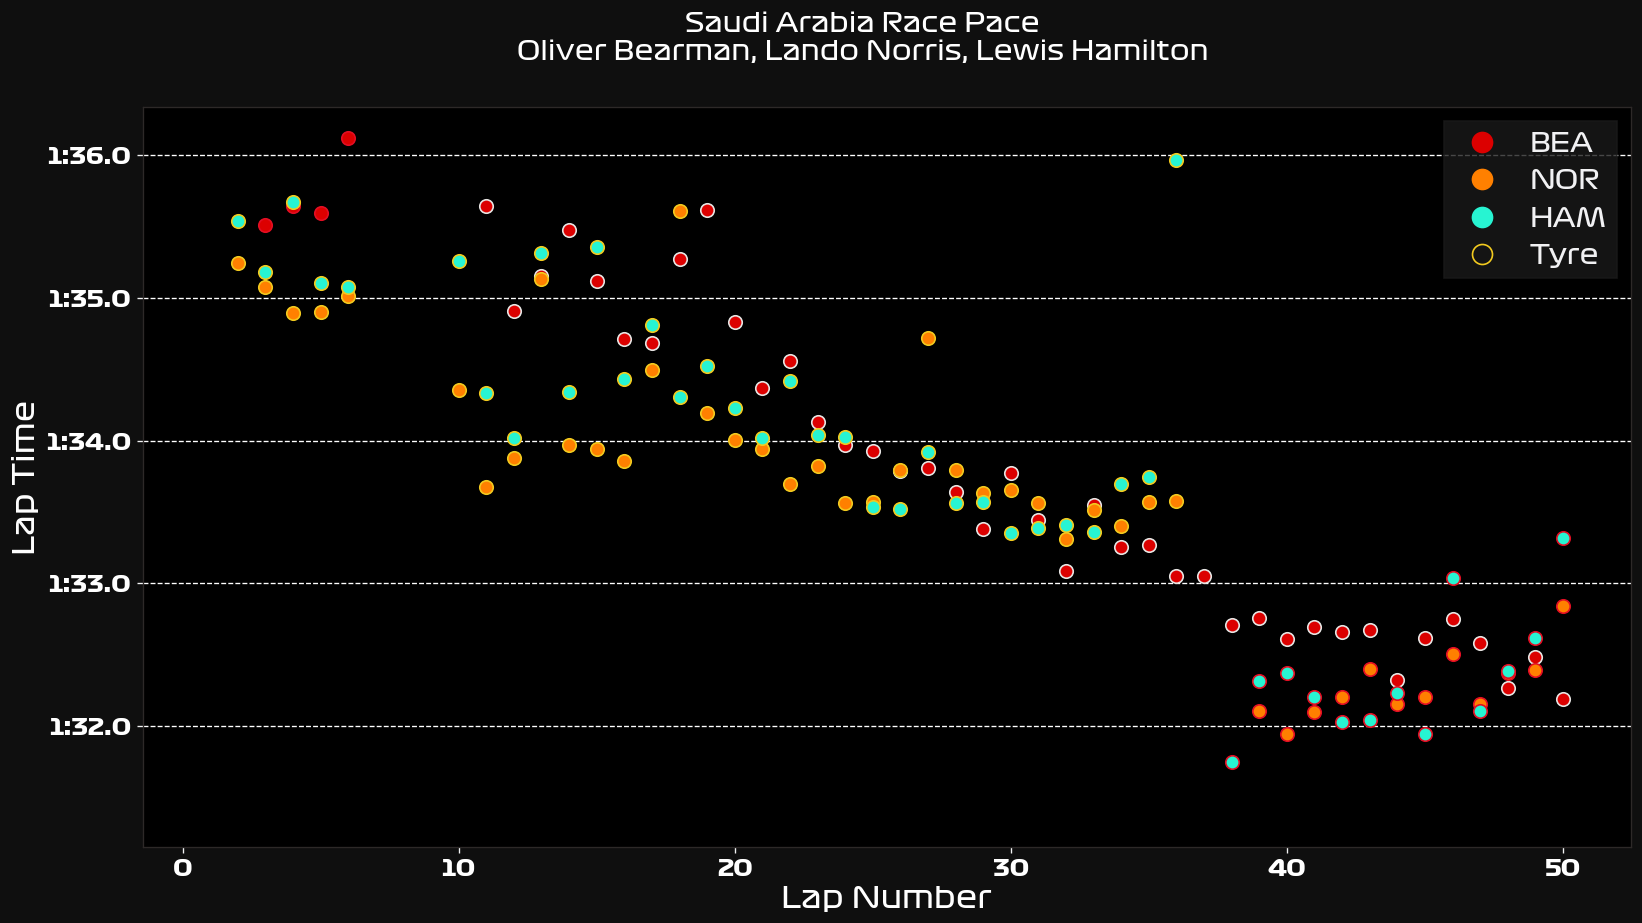

In [4]:
'''LAP TIME PLOTTING'''


'''setup'''
drivers_in_graph = ["BEA", "NOR", "HAM"]  # enter drivers to compare

axis_fontsize = 18
tick_fontsize = 14


'''axis settings'''
plt.figure(figsize=(16,8), dpi=120, facecolor="#0F0F0F")
plt.yticks(color="white", fontsize=tick_fontsize, fontname="Formula1")
plt.xticks(color="white", fontsize=tick_fontsize, fontname="Formula1")
plt.xlabel("Lap Number", fontsize=axis_fontsize, color="white", fontname="Formula1")
plt.ylabel("Lap Time", fontsize=axis_fontsize, color="white", fontname="Formula1")

ax = plt.gca()
ax.patch.set_facecolor("#000000")

ax.set_axisbelow(True)
ax.yaxis.grid(True, which="major", linestyle="--", color="white", zorder=-1000)
plt.ylim(bottom=0.001055 , top=0.001115)
# plt.xlim(0, 332)

'''tyre data for any drivers in the list'''

teams_in_graph = list()
handles = list()


# SCATTER
for driver in drivers_in_graph:
    driver = driver.upper()
    current_team = drivers[driver]["Team"]
    team_colour = team_colours[current_team]
    team_data = all_laps_by_team[current_team]
    driver_laps = team_data[team_data["Driver"] == driver].reset_index()

    # if two drivers are of the same team, the dots in the scatter are squares
    # also gives them the legend handle with the correct colour and name
    if current_team not in teams_in_graph:
        marker = "o"
        dot_size = 65
        handle = mlines.Line2D([],[], linestyle="None", color=team_colour, marker=marker, markersize=12, label=driver)
    else:
        marker = "*"
        dot_size = 100
        handle = mlines.Line2D([],[], linestyle="None", color=team_colour, marker=marker, markersize=12, label=driver)

    teams_in_graph.append(current_team)
    handles.append(handle)


    # splitting drivers laps by tyre
    laps_by_tyre = {
        "soft": driver_laps[driver_laps["Compound"] == "SOFT"],
        "medium": driver_laps[driver_laps["Compound"] == "MEDIUM"],
        "hard": driver_laps[driver_laps["Compound"] == "HARD"]
    }
    
    for tyre, tyre_laps in laps_by_tyre.items():
        ax.scatter(
            tyre_laps.LapNumber, tyre_laps.LapTime,
            color=team_colour, s=dot_size, linewidths=1, edgecolors=tyre_colours[tyre], marker=marker,
        )

# LEGEND
handle = mlines.Line2D(
    [], [], linestyle="None",
    marker="o", markerfacecolor="None", markeredgecolor=tyre_colours["medium"], markersize=12,
    label="Tyre"
)
handles.append(handle)
ax.legend(handles=handles, prop=font)

# TITLE
title = f"{grand_prix} Race Pace\n"
for driver in drivers_in_graph:
    title = title + f"{drivers[driver]["Full Name"]}, "
title = title[:-2]
plt.suptitle(title, fontsize=16, fontname="Formula1", color="white")


plt.show()


In [5]:
'''setup'''

def laptime_scatter_trend(drivers_in_graph: list):
    drivers_in_graph = drivers_in_graph

    axis_fontsize = 16
    tick_fontsize = 12

    teams_in_graph = list()
    handles = list()
    max_time = None
    min_time = None

    plt.figure(figsize=(16,8), dpi=120)


    with sns.axes_style():
        for driver in drivers_in_graph:

            # GETTING INITIAL INFO ABOUT EACH DRIVER
            driver = driver.upper()
            current_team = drivers[driver]["Team"]
            team_colour = team_colours[current_team]
            driver_laps = all_laps_by_team[current_team][all_laps_by_team[current_team]["Driver"] == driver].reset_index()
            driver_laps = driver_laps[(driver_laps['PitInTime'].isnull()) & (driver_laps['PitOutTime'].isnull())]  # removing box laps

            # if two drivers are of the same team, the dots in the scatter are squares
            # also gives them the legend handle with the correct colour and name
            if current_team not in teams_in_graph:
                marker = "o"
                best_fit_line_style = "-"
                dot_size = 65
                handle = mlines.Line2D([],[], linestyle="-", color=team_colour, marker=marker, markersize=12, label=driver)
            else:
                marker = "*"
                best_fit_line_style = "--"
                dot_size = 100
                handle = mlines.Line2D([],[], linestyle="--", color=team_colour, marker=marker, markersize=12, label=driver)

            teams_in_graph.append(current_team)
            handles.append(handle)


            # CREATING THE SCATTER PLOTS FOR EACH TYRE AND DRIVER
            # splitting drivers laps by tyre
            laps_by_tyre = {"soft": None, "medium": None, "hard": None}

            for tyre, tyre_laps in laps_by_tyre.items():

                tyre_laps = driver_laps[driver_laps["Compound"] == tyre.upper()].dropna(subset="LapTime", inplace=False)
                mean = tyre_laps["LapTime"].mean(numeric_only=False)
                std = tyre_laps["LapTime"].std(numeric_only=False)
                tyre_laps = tyre_laps[tyre_laps["LapTime"] < (mean + std)]


                # GRAPHS THEMSELVES
                try:
                    ax = sns.regplot(
                        data=tyre_laps, x="LapNumber", y="LapTime",
                        scatter=True,
                        marker=marker,
                        scatter_kws = {"color": team_colour, "alpha": 1, "linewidths": 1.5, "edgecolor": tyre_colours[tyre], "s": dot_size},
                        line_kws = {"color": team_colour, "linestyle": best_fit_line_style}
                    )
                except TypeError:  # will get TypeError if a tyre hasn't been used
                    pass
                
                # SETTING Y AXIS LIMITS. FINDS THE HIGHEST AND LOWEST POINTS IN THE GRAPH
                min_time_tyre = tyre_laps["LapTime"].min()
                max_time_tyre = tyre_laps["LapTime"].max()
              
                if not np.isnat(min_time_tyre.to_numpy()):
                    if min_time == None:
                        min_time = min_time_tyre
                    elif (
                        min_time_tyre.seconds < min_time.seconds or
                        min_time_tyre.seconds == min_time.seconds and min_time_tyre.microseconds < min_time.microseconds
                        ):
                        min_time = min_time_tyre

                if not np.isnat(max_time_tyre.to_numpy()):
                    if max_time == None:
                        max_time = max_time_tyre
                    elif (
                        max_time_tyre.seconds > max_time.seconds or
                        max_time_tyre.seconds == max_time.seconds and max_time_tyre.microseconds > max_time.microseconds
                        ):
                        max_time = max_time_tyre

    
    # SAFETY CAR VERTICAL LINES AND LABEL
    for sc in sc_laps:
        start_lap, end_lap = sc
        plt.vlines(
            x=start_lap, ymin=min_time * 0.999, ymax=max_time * 1.001,
            linestyles="dotted", colors=tyre_colours["medium"]
        )
        plt.vlines(
            x=end_lap, ymin=min_time * 0.999, ymax=max_time * 1.001,
            linestyles="dotted", colors=tyre_colours["medium"]
        )
        half_way_sc = (end_lap - start_lap) / 2 + start_lap
        plt.text(
            x=half_way_sc, y=max_time * 0.998,
            s="SC", fontsize=16, fontname="Formula1", horizontalalignment='center', color=tyre_colours["medium"]
        )


    # LEGEND
    handle = mlines.Line2D(
        [], [], linestyle="None",
        marker="o", markerfacecolor="None", markeredgecolor=tyre_colours["medium"], markersize=12,
        label="Tyre"
    )
    handles.append(handle)
    l = ax.legend(handles=handles, prop=font)
    for text in l.get_texts():
        text.set_color("white")

    # TITLE
    title = f"{grand_prix} Race Pace\n"
    for driver in drivers_in_graph:
        title = title + f"{drivers[driver]["Full Name"]}, "
    title = title[:-2]
    plt.suptitle(title, fontsize=16, fontname="Formula1", color="white")

    # STYLE AND AXES
    sns.set_theme(rc={"axes.facecolor" : "black", "figure.facecolor": "#0F0F0F"})
    ax.grid(False)
    ax.yaxis.grid(True, which="major", linestyle="--", color="white", zorder=-1000)
    ax.set(
        ylim=(min_time * 0.999, max_time * 1.001),
        xlim=(0, current_race["Laps"] + 1)
    )

    # SETTING LAP TIME FORMAT
    time_format = mdates.DateFormatter("%M:%S")
    ax.yaxis.set_major_formatter(time_format)

    plt.yticks(color="white", fontsize=tick_fontsize, fontname="Formula1")
    plt.xticks(color="white", fontsize=tick_fontsize, fontname="Formula1")
    plt.xlabel("Lap Number", fontsize=axis_fontsize, color="white", fontname="Formula1")
    plt.ylabel("Lap Time", fontsize=axis_fontsize, color="white", fontname="Formula1")

    plt.show()


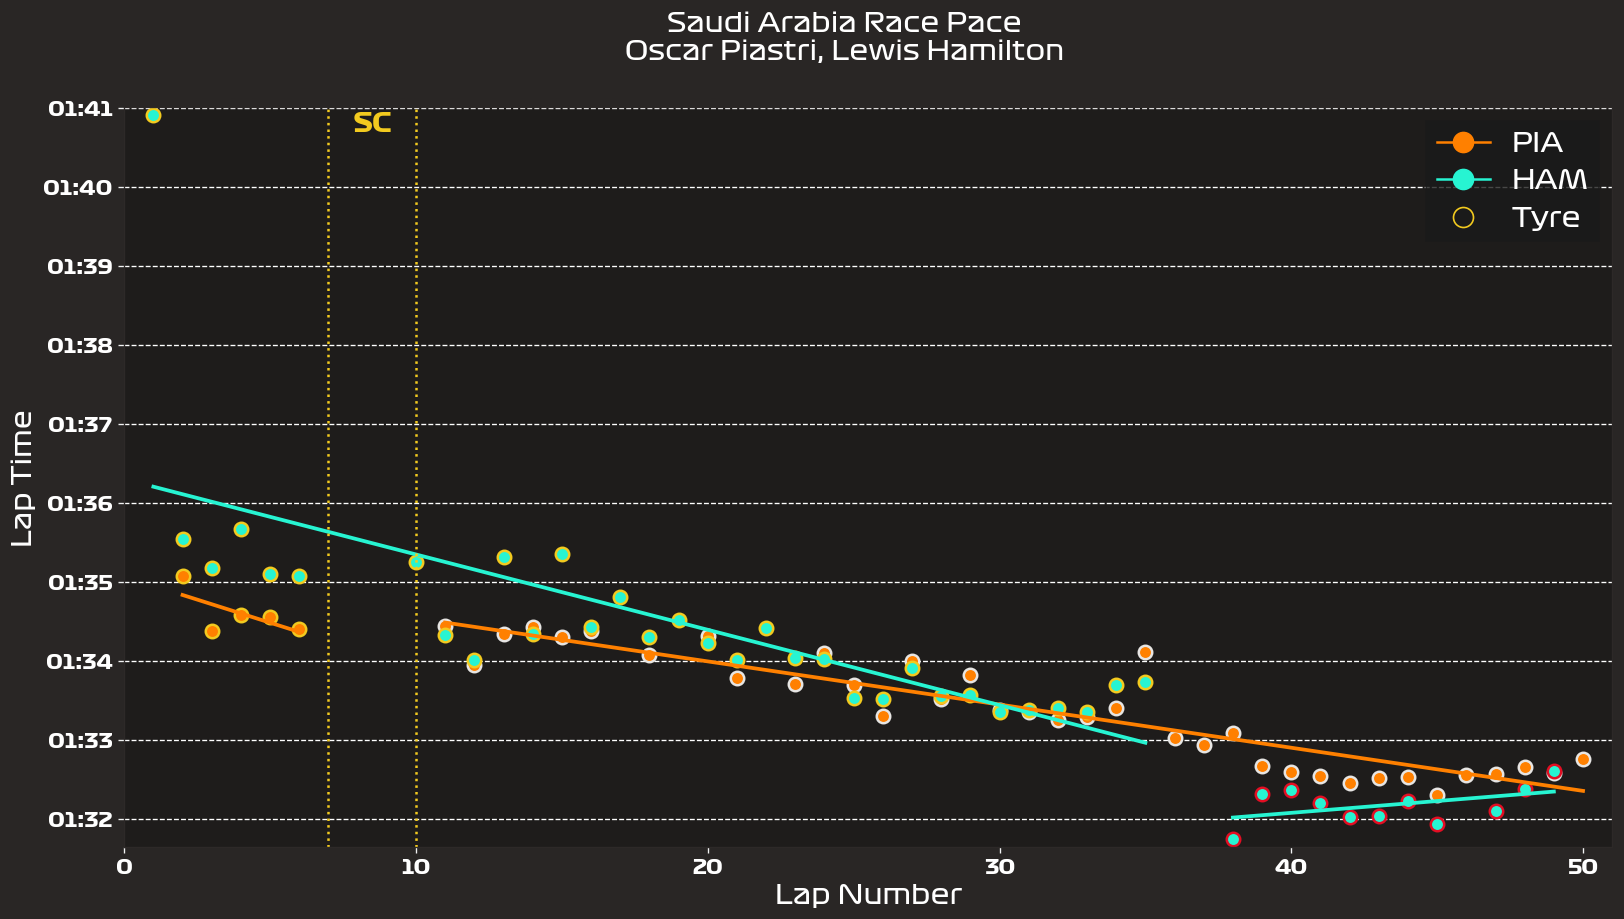

In [6]:
drivers_in_graph = ["PIA", "HAM"]

laptime_scatter_trend(drivers_in_graph)

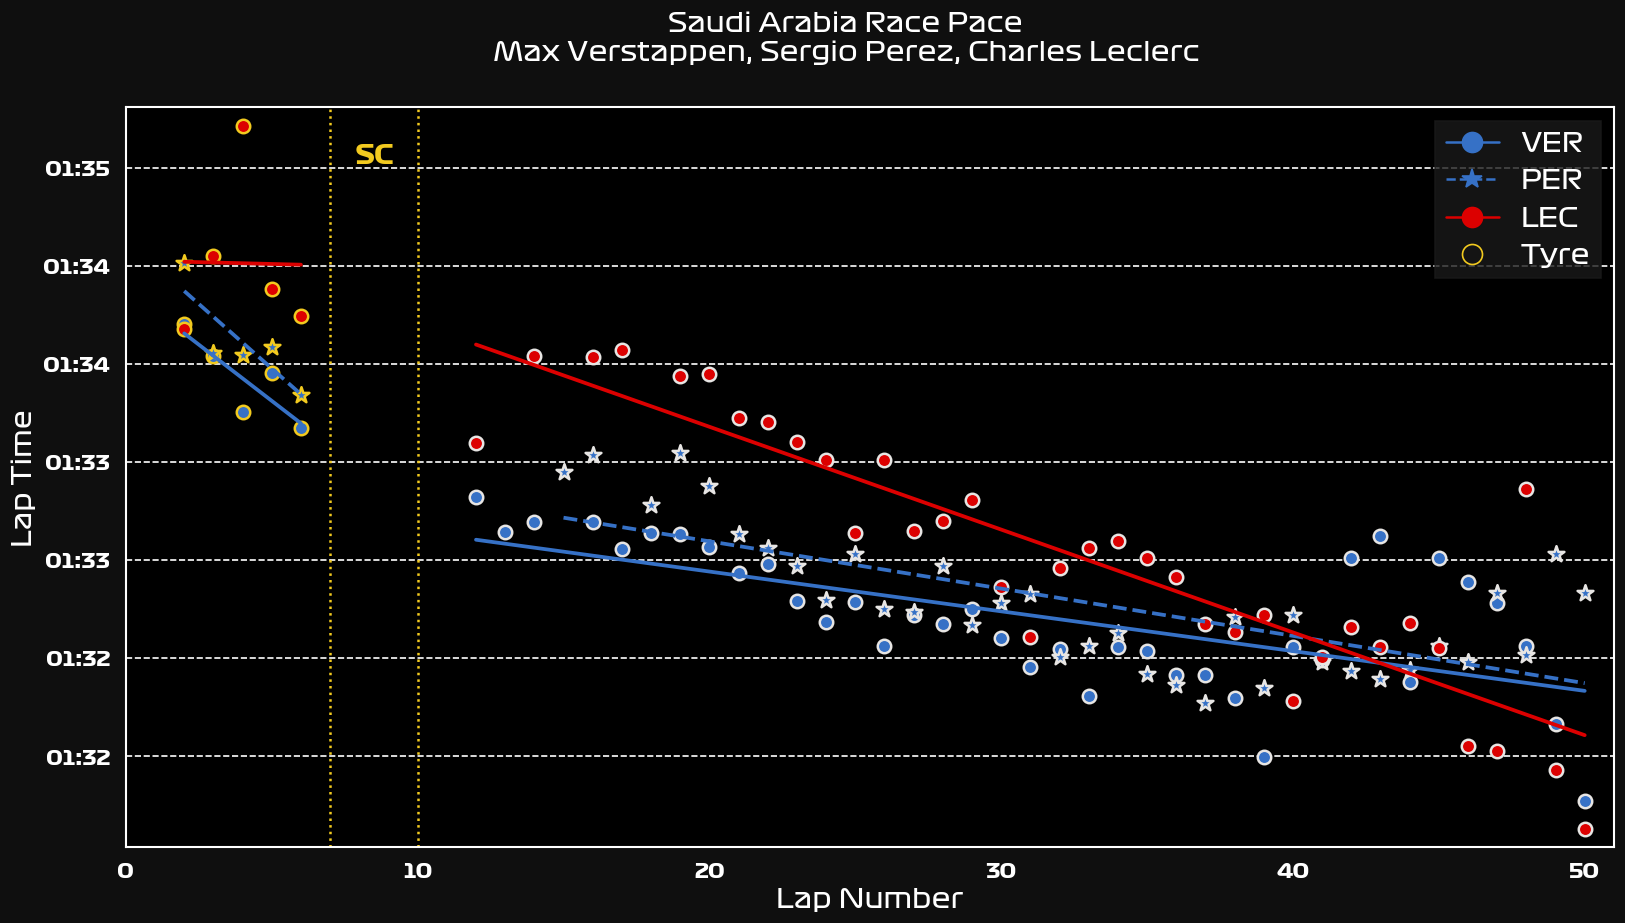

In [7]:
drivers_in_graph = ["VER", "PER", "LEC"]

laptime_scatter_trend(drivers_in_graph)

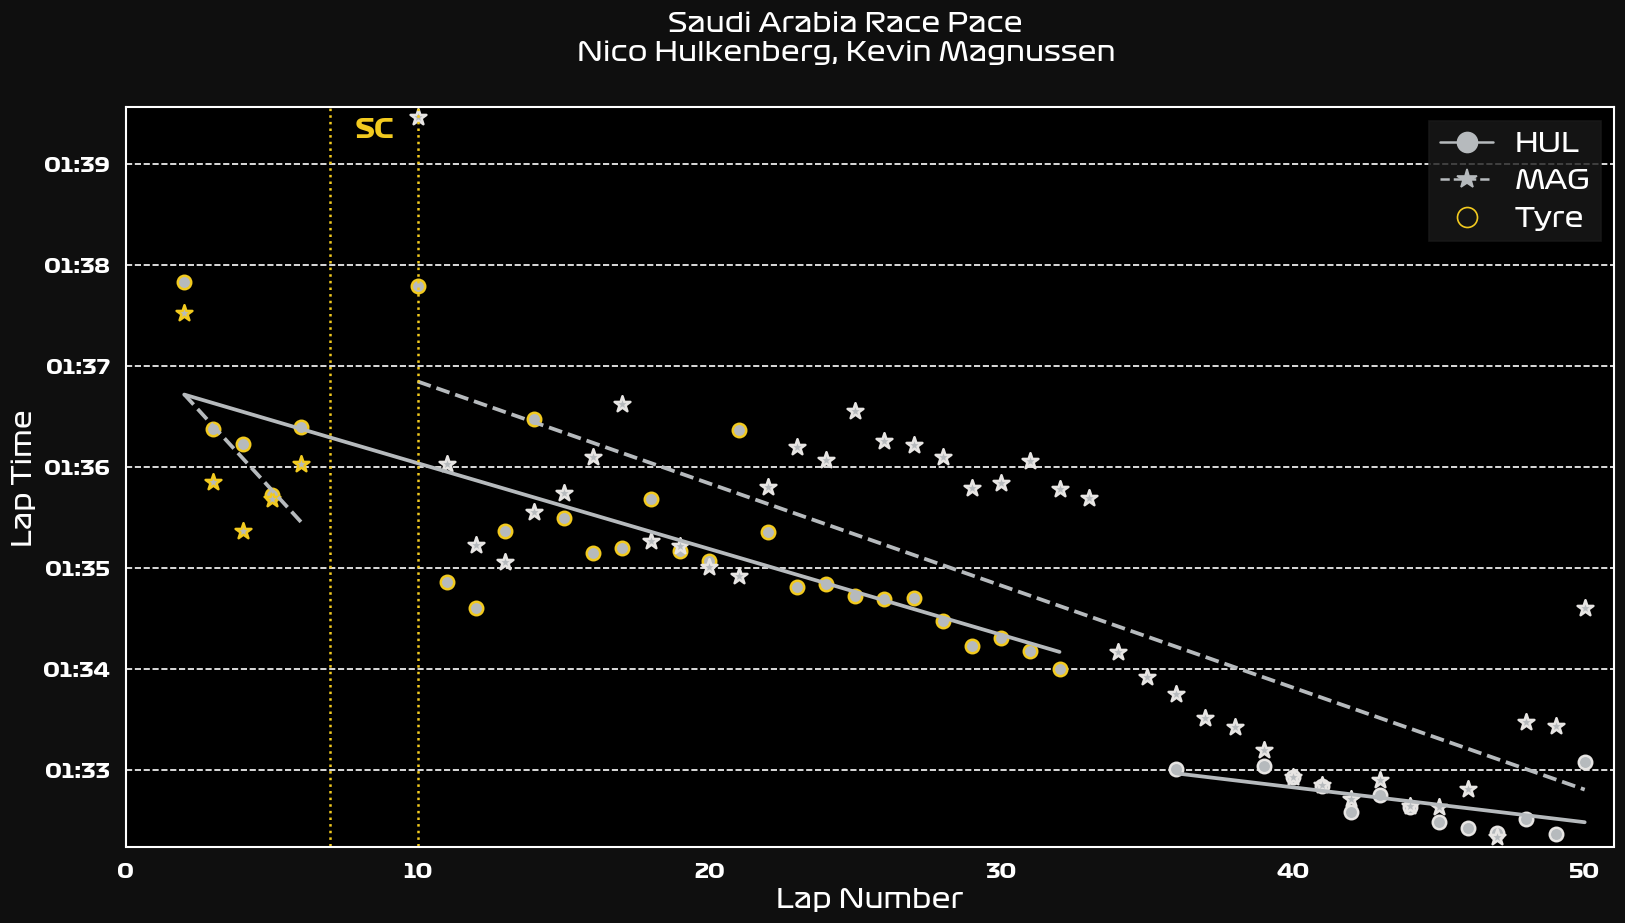

In [8]:
drivers_in_graph = ["HUL", "MAG"]

laptime_scatter_trend(drivers_in_graph)

In [34]:
'''TELEMETRY DATA'''

def compare_specific_laps(driver1: str, driver2: str, lap_number: int, driver1_overwrite_colour=None, driver2_overwrite_colour=None, dotswap=False):
    '''
    Shows the telemetry data for two drivers on any specific lap. Inputs are "driver1" and "driver2" as the driver initials, and the lap number to compare.
    Also takes overwrite colours for either driver. By default "None" and so drivers will get their team colour.
    '''

    driver1 = driver1
    driver2 = driver2 
    lap_number = lap_number

    axis_fontsize = 18
    tick_fontsize = 14

    team1 = drivers[driver1]["Team"]
    team2 = drivers[driver2]["Team"]
    team1_colour = team_colours[team1]
    team2_colour = team_colours[team2]

    if driver1_overwrite_colour != None:
        team1_colour = driver1_overwrite_colour

    if driver2_overwrite_colour != None:  
        team2_colour = driver2_overwrite_colour

    lap1 = LAPS.pick_driver(driver1).pick_lap(lap_number).iloc[0]
    lap2 = LAPS.pick_driver(driver2).pick_lap(lap_number).iloc[0]

    lap1_tel = lap1.get_car_data().add_distance()
    lap2_tel = lap2.get_car_data().add_distance()

    delta_time, ref_tel, compare_tel = utils.delta_time(lap1, lap2)

    v_max = lap1_tel["Speed"].max()

    '''GRAPH START'''

    fig, ax = plt.subplots(nrows=3, height_ratios=[3, 1, 1], figsize=(16,12), dpi=120, facecolor="#0F0F0F")
    
    # DRIVER LINESTYLES. IF OF SAME TEAM, SECOND IS DASHED, IF THERE IS NO OVERWRITE COLOUR FOR DRIVER 2
    if dotswap == False and driver2_overwrite_colour == None and team1 == team2: 
        driver1_linestyle = "-"
        driver2_linestyle = "dotted"
    elif dotswap == True and driver2_overwrite_colour == None and team1 == team2:
        driver1_linestyle = "dotted"
        driver2_linestyle = "-"
    else:
        driver1_linestyle = "-"
        driver2_linestyle = "-"


    # CORNER LINES
    for _, corner in circuit_info.corners.iterrows():
        txt = f"{corner["Number"]}{corner["Letter"]}"
        ax[0].text(corner["Distance"], v_max+20, txt, va="center_baseline", ha="center", size="medium", fontname="Formula1", color="white")

    # CORNER MINOR AXIS LINE LOCATIONS
    corner_location = circuit_info.corners["Distance"]
    minor_tick_locations = list()
    for corner in corner_location:
        minor_tick_locations.append(corner)


    # PLOTTING THE LINES
    ax[0].plot(lap1_tel["Distance"], lap1_tel["Speed"], color=team1_colour, label=driver1, linestyle=driver1_linestyle, linewidth=2)
    ax[0].plot(lap2_tel["Distance"], lap2_tel["Speed"], color=team2_colour, label=driver2, linestyle=driver2_linestyle, linewidth=2)

    ax[1].plot(lap1_tel["Distance"], lap1_tel["Throttle"], color=team1_colour, label=driver1, linestyle=driver1_linestyle, linewidth=2)
    ax[1].plot(lap2_tel["Distance"], lap2_tel["Throttle"], color=team2_colour, label=driver2, linestyle=driver2_linestyle, linewidth=2)

    ax[2].plot(ref_tel["Distance"], delta_time, color="white", linewidth=3)
    ax[2].axhline(y=0, color="gray")
    plt.xticks(color="white")

    l = ax[0].legend(facecolor="black", labelcolor="white")
    plt.setp(l.texts, family="Formula1", size=axis_fontsize)


    ax[0].get_xaxis().set_ticklabels([])
    ax[1].get_xaxis().set_ticklabels([])
    ax[2].set_xlabel("Distance [metres]", fontname="Formula1", fontsize=axis_fontsize, color="white")

    y_labels = ["Speed [km/h]", "Throttle [%]", "Delta [s]"]
    for n in range(0,3):
        ax[n].tick_params(labelsize=tick_fontsize)
        ax[n].patch.set_facecolor("black")
        ax[n].set_ylabel(y_labels[n], fontname="Formula1", fontsize=axis_fontsize, color="white")

        ax[n].xaxis.set_minor_locator(FixedLocator(minor_tick_locations))
        ax[n].grid(which="minor", linestyle="-", linewidth=3, color="#333333")
        ax[n].grid(which="minor", axis="y", linewidth=0)
        ax[n].grid(which="major", axis="x", linestyle="-", linewidth=2)

        ax[n].tick_params(axis="y", colors="white")


    fastest_lap_time = strftimedelta(lap1["LapTime"], "%m:%s.%ms")
    diff = strftimedelta(lap2["LapTime"] - lap1["LapTime"], "%s.%ms")
    plt.suptitle(f"Lap {lap_number} Comparison, {data.event["EventName"]} {data.event.year}\n{driver1}: {fastest_lap_time}, {driver2}: +{diff}s",
                fontsize=20, fontname="Formula1", color="white")

    fig.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.05)
    plt.show()


c:\Users\maxvo\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastf1\utils.py:91: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


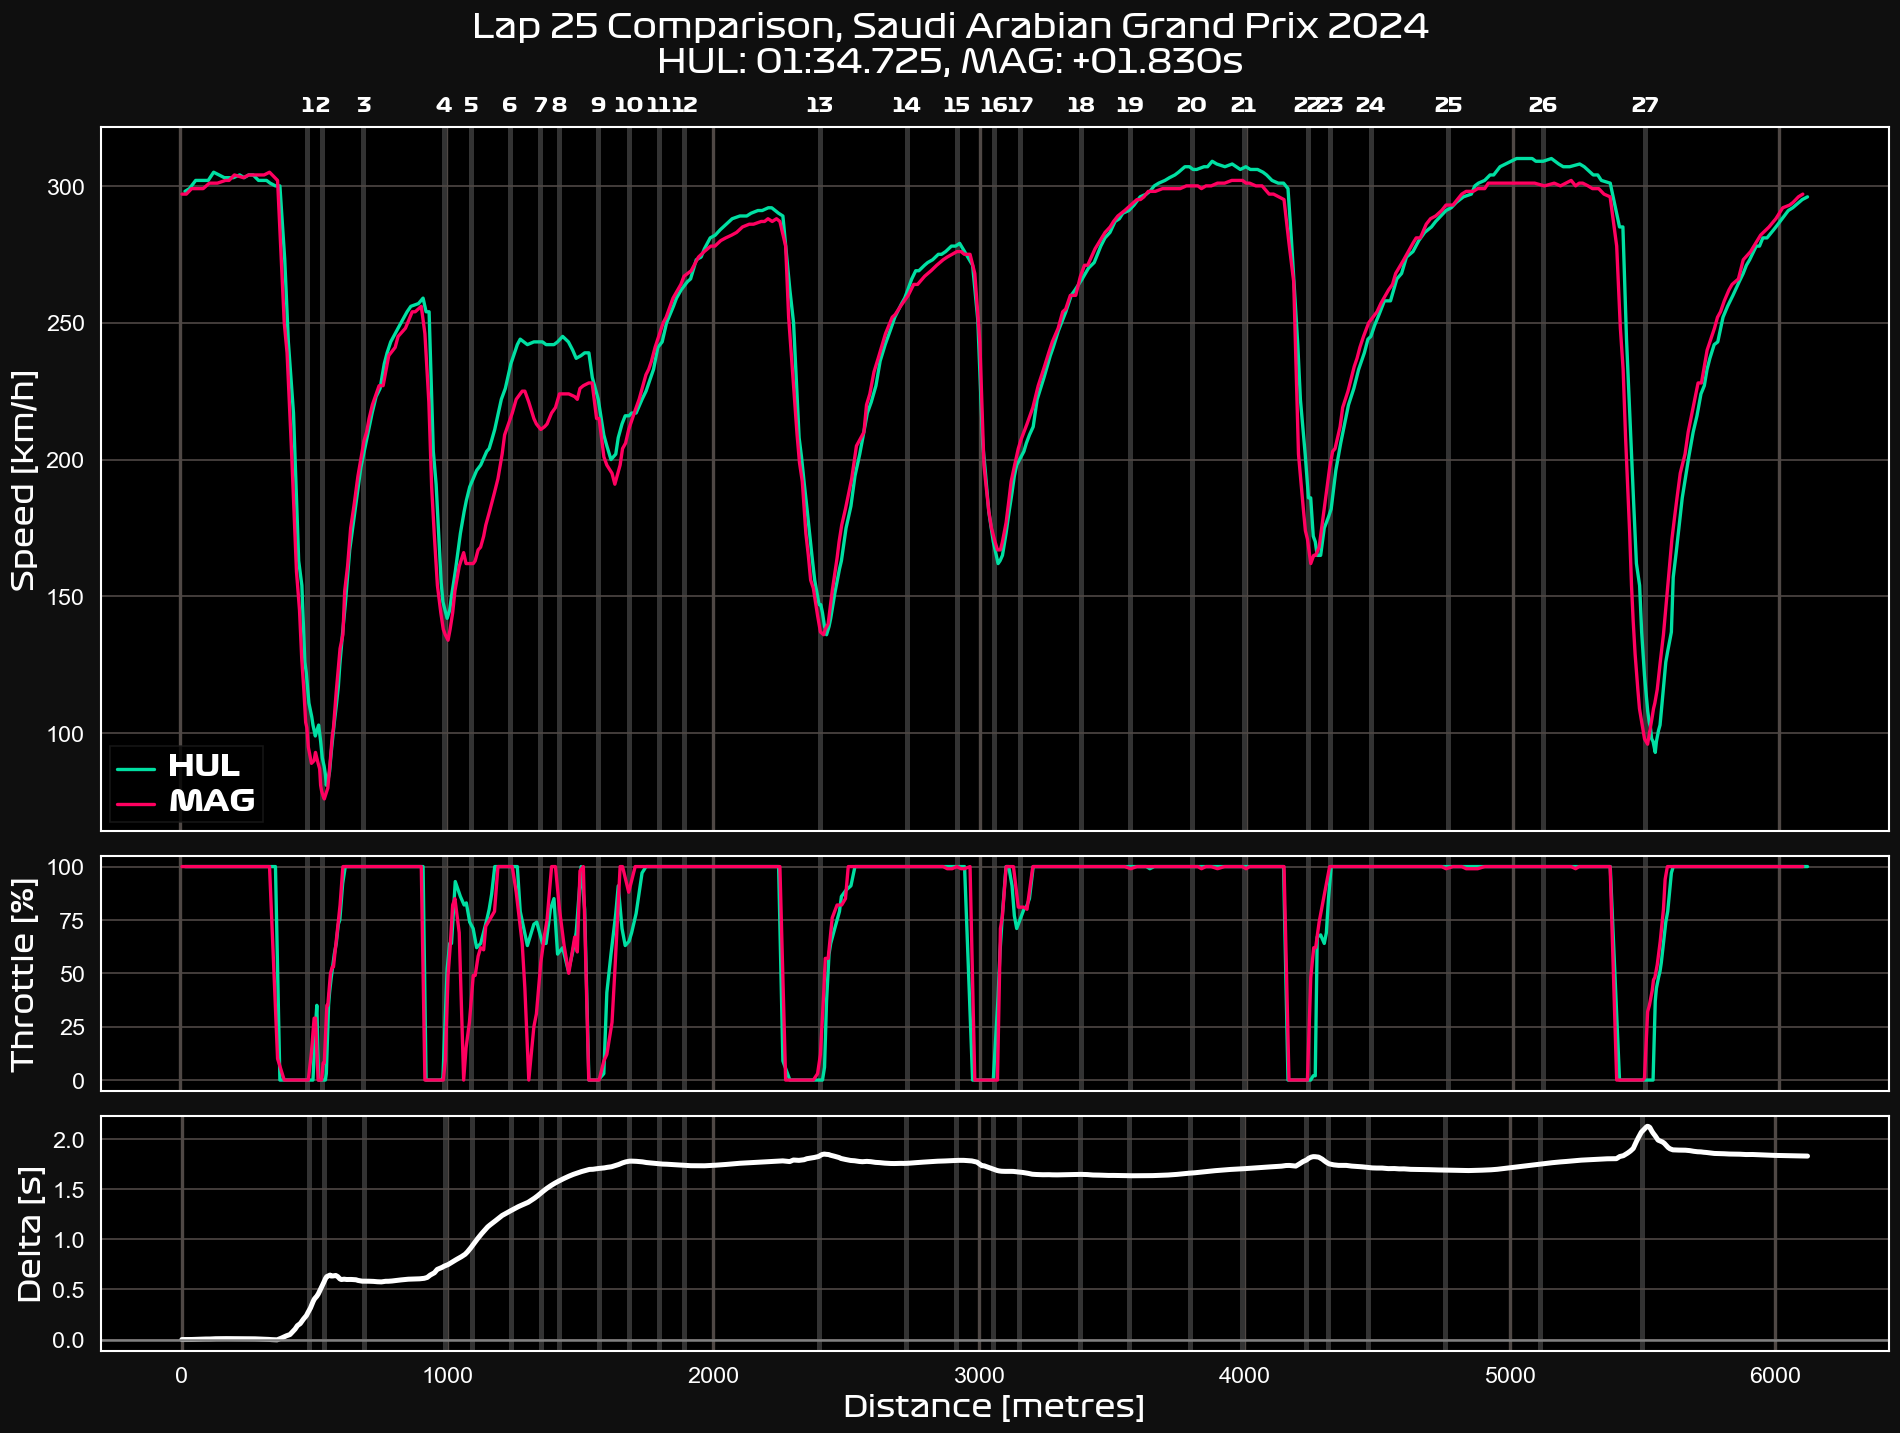

In [33]:
compare_specific_laps("HUL", "MAG", 25, "#00DFA2", "#FF0060", dotswap=True)

In [15]:
mag_laps = LAPS[LAPS["Driver"] == "MAG"]
hul_laps = LAPS[LAPS["Driver"] == "HUL"]

mag_laps["HUL Delta"] = hul_laps["LapTime"] - mag_laps["LapTime"]

C:\Users\maxvo\AppData\Local\Temp\ipykernel_26512\1847090629.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mag_laps["HUL Delta"] = hul_laps["LapTime"] - mag_laps["LapTime"]


In [17]:
hul_laps

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
454,0 days 01:01:27.939000,HUL,27,0 days 00:01:43.748000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:30.902000,...,True,Haas F1 Team,0 days 00:59:43.836000,2024-03-09 17:03:59.056,1,14.0,False,,False,False
455,0 days 01:03:05.775000,HUL,27,0 days 00:01:37.836000,2.0,1.0,NaT,NaT,0 days 00:00:37.559000,0 days 00:00:30.401000,...,True,Haas F1 Team,0 days 01:01:27.939000,2024-03-09 17:05:43.159,1,14.0,True,TRACK LIMITS AT TURN 2 LAP 2,False,True
456,0 days 01:04:42.157000,HUL,27,0 days 00:01:36.382000,3.0,1.0,NaT,NaT,0 days 00:00:36.146000,0 days 00:00:30.285000,...,True,Haas F1 Team,0 days 01:03:05.775000,2024-03-09 17:07:20.995,1,14.0,False,,False,True
457,0 days 01:06:18.388000,HUL,27,0 days 00:01:36.231000,4.0,1.0,NaT,NaT,0 days 00:00:35.786000,0 days 00:00:30.354000,...,True,Haas F1 Team,0 days 01:04:42.157000,2024-03-09 17:08:57.377,1,14.0,False,,False,True
458,0 days 01:07:54.111000,HUL,27,0 days 00:01:35.723000,5.0,1.0,NaT,NaT,0 days 00:00:35.486000,0 days 00:00:30.198000,...,True,Haas F1 Team,0 days 01:06:18.388000,2024-03-09 17:10:33.608,1,14.0,False,,False,True
459,0 days 01:09:30.509000,HUL,27,0 days 00:01:36.398000,6.0,1.0,NaT,NaT,0 days 00:00:35.701000,0 days 00:00:30.239000,...,True,Haas F1 Team,0 days 01:07:54.111000,2024-03-09 17:12:09.331,2,13.0,False,,False,True
460,0 days 01:11:40.233000,HUL,27,0 days 00:02:09.724000,7.0,1.0,NaT,NaT,0 days 00:00:43.360000,0 days 00:00:43.579000,...,True,Haas F1 Team,0 days 01:09:30.509000,2024-03-09 17:13:45.729,24,13.0,False,,False,False
461,0 days 01:14:30.629000,HUL,27,NaT,8.0,1.0,NaT,NaT,0 days 00:00:54.729000,0 days 00:00:57.519000,...,True,Haas F1 Team,0 days 01:11:40.233000,2024-03-09 17:15:55.453,4,8.0,False,,False,False
462,0 days 01:17:03.736000,HUL,27,NaT,9.0,1.0,NaT,NaT,0 days 00:00:54.683000,0 days 00:00:49.385000,...,True,Haas F1 Team,0 days 01:14:30.629000,2024-03-09 17:18:45.849,4,8.0,False,,False,False
463,0 days 01:18:41.532000,HUL,27,0 days 00:01:37.796000,10.0,1.0,NaT,NaT,0 days 00:00:37.449000,0 days 00:00:30.017000,...,True,Haas F1 Team,0 days 01:17:03.736000,2024-03-09 17:21:18.956,1,8.0,False,,False,False


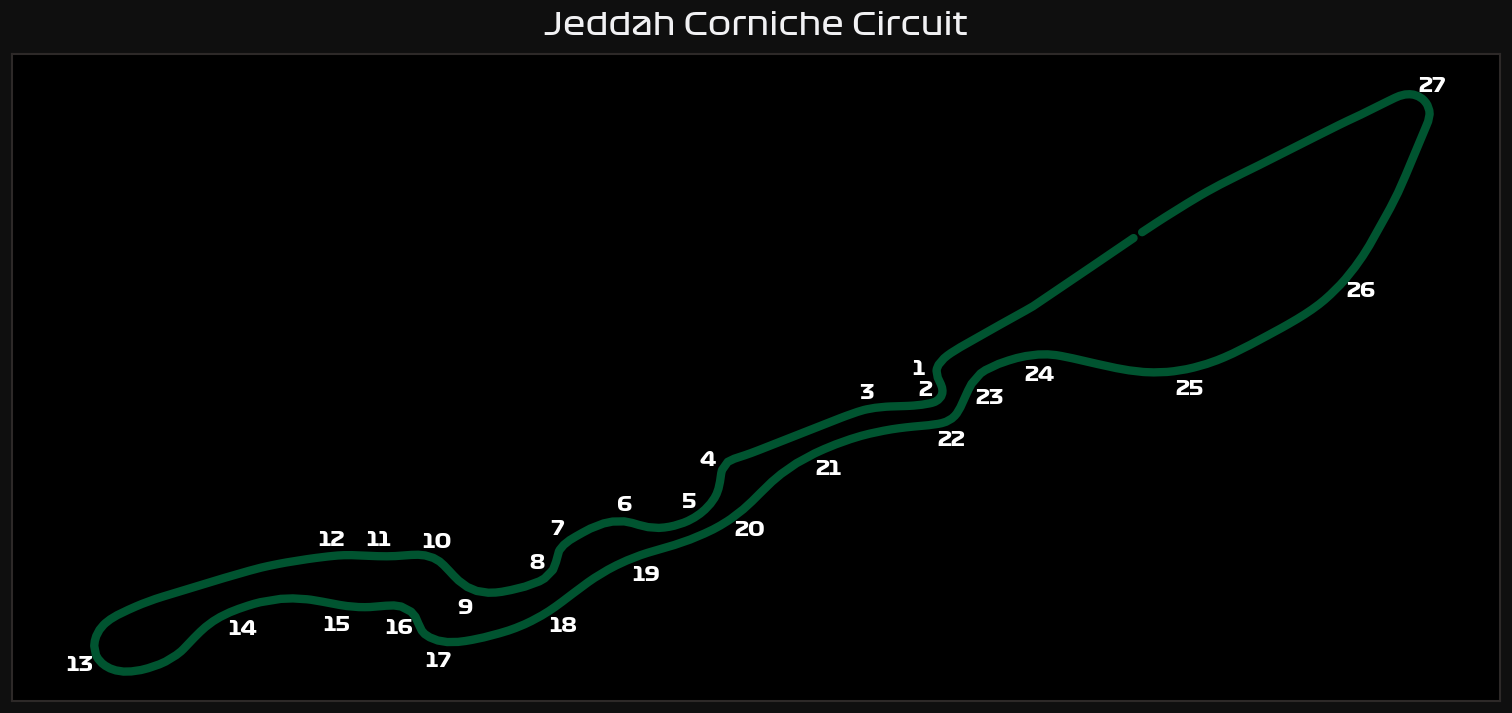

In [76]:
def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

lap = LAPS.pick_fastest()
pos = lap.get_pos_data()

track = pos.loc[:, ('X', 'Y')].to_numpy()

# Convert the rotation angle from degrees to radian.
track_angle = circuit_info.rotation / 180 * np.pi

plt.figure(figsize=(16,7), dpi=120, facecolor="#0F0F0F")
ax = plt.gca()
ax.patch.set_facecolor("#000000")

# Rotate and plot the track map.
rotated_track = rotate(track, angle=track_angle)
plt.plot(rotated_track[:, 0], rotated_track[:, 1], color="#005430", linewidth=5)

offset_vector = [350, 0]  # offset length is chosen arbitrarily to 'look good'

# Iterate over all corners.
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Rotate the text position equivalently to the rest of the track map
    text_x, text_y = rotate([text_x, text_y], angle=track_angle)

    # Rotate the center of the corner equivalently to the rest of the track map
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=track_angle)

    # Draw a circle next to the track.
    plt.scatter(text_x, text_y, color='black', s=280)

    # Draw a line from the track to this circle.
    # plt.plot([track_x, text_x], [track_y, text_y], color='black')

    # Finally, print the corner number inside the circle.
    plt.text(text_x, text_y, txt,
             va='center_baseline', ha='center', size=12, color='white', fontname="Formula1")

plt.title("Jeddah Corniche Circuit", fontname="Formula1")
plt.xticks([])
plt.yticks([])
plt.axis('equal')
plt.show()